<a href="https://colab.research.google.com/github/RUZaman/colab/blob/main/work_ucf101_subset_ac_98_transfer_learning_with_movinet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/transfer_learning_with_movinet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/transfer_learning_with_movinet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/transfer_learning_with_movinet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Transfer learning for video classification with MoViNet

MoViNets (Mobile Video Networks) provide a family of efficient video classification models, supporting inference on streaming video. In this tutorial, you will use a pre-trained MoViNet model to classify videos, specifically for an action recognition task, from the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php). A pre-trained model is a saved network that was previously trained on a larger dataset. You can find more details about MoViNets in the [MoViNets: Mobile Video Networks for Efficient Video Recognition](https://arxiv.org/abs/2103.11511) paper by Kondratyuk, D. et al. (2021). In this tutorial, you will: 

* Learn how to download a pre-trained MoViNet model
* Create a new model using a pre-trained model with a new classifier by freezing the convolutional base of the MoViNet model
* Replace the classifier head with the number of labels of a new dataset
* Perform transfer learning on the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php)

The model downloaded in this tutorial is from [official/projects/movinet](https://github.com/tensorflow/models/tree/master/official/projects/movinet). This repository contains a collection of MoViNet models that TF Hub uses in the TensorFlow 2 SavedModel format.

This transfer learning tutorial is the third part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document; in particular, how to preprocess and load data through the `FrameGenerator` class is explained in more detail.
- [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification). Note that this tutorial uses a (2+1)D CNN that decomposes the spatial and temporal aspects of 3D data; if you are using volumetric data such as an MRI scan, consider using a 3D CNN instead of a (2+1)D CNN.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files (ensure that `opencv-python` and `opencv-python-headless` are the same version), and TensorFlow models ([`tf-models-official`](https://github.com/tensorflow/models/tree/master/official)) to download the pre-trained MoViNet model. The TensorFlow models package are a collection of models that use TensorFlow’s high-level APIs.

In [1]:
!pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 

In [2]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

## Load data
 
The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. The [Loading video data tutorial](https://www.tensorflow.org/tutorials/load_data/video) provides a detailed walkthrough of this code.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.



In [3]:
#@title 

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [4]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "test": 20}, 
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [00:42<00:00,  7.04it/s]


test :


100%|██████████| 200/200 [00:22<00:00,  8.77it/s]


Create the training and test datasets:

In [8]:
batch_size = 8
num_frames = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

The labels generated here represent the encoding of the classes. For instance, 'ApplyEyeMakeup' is mapped to the integer Take a look at the labels of the training data to ensure that the dataset has been sufficiently shuffled. 

In [11]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor([4 9 2 4 2 4 4 9], shape=(8,), dtype=int16)
tf.Tensor([8 2 2 2 1 1 9 2], shape=(8,), dtype=int16)
tf.Tensor([4 5 5 9 5 9 1 1], shape=(8,), dtype=int16)
tf.Tensor([1 9 9 0 0 6 8 9], shape=(8,), dtype=int16)
tf.Tensor([2 2 7 4 6 6 4 5], shape=(8,), dtype=int16)
tf.Tensor([6 6 6 5 6 1 9 6], shape=(8,), dtype=int16)
tf.Tensor([6 0 6 3 3 0 4 0], shape=(8,), dtype=int16)
tf.Tensor([2 9 6 8 3 5 8 0], shape=(8,), dtype=int16)
tf.Tensor([2 3 1 3 9 7 0 7], shape=(8,), dtype=int16)
tf.Tensor([8 4 7 5 7 9 5 5], shape=(8,), dtype=int16)


Take a look at the shape of the data.

In [13]:
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (8, 8, 224, 224, 3)
Label: (8,)


## What are MoViNets?

As mentioned previously, [MoViNets](https://arxiv.org/abs/2103.11511) are video classification models used for streaming video or online inference in tasks, such as action recognition. Consider using MoViNets to classify your video data for action recognition.

A 2D frame based classifier is efficient and simple to run over whole videos, or streaming one frame at a time. Because they can't take temporal context into account they have limited accuracy and may give inconsistent outputs from frame to frame.

A simple 3D CNN uses bidirectional temporal context which can increase accuracy and temporal consistency. These networks may require more resources and because they look into the future they can't be used for streaming data.

![Standard convolution](https://www.tensorflow.org/images/tutorials/video/standard_convolution.png)

The MoViNet architecture uses 3D convolutions that are "causal" along the time axis (like `layers.Conv1D` with `padding="causal"`). This gives some of the advantages of both approaches, mainly it allow for efficient streaming.

![Causal convolution](https://www.tensorflow.org/images/tutorials/video/causal_convolution.png)

Causal convolution ensures that the output at time *t* is computed using only inputs up to time *t*. To demonstrate how this can make streaming more efficient, start with a simpler example you may be familiar with: an RNN. The RNN passes state forward through time:

![RNN model](https://www.tensorflow.org/images/tutorials/video/rnn_comparison.png)

In [14]:
gru = layers.GRU(units=4, return_sequences=True, return_state=True)

inputs = tf.random.normal(shape=[1, 10, 8]) # (batch, sequence, channels)

result, state = gru(inputs) # Run it all at once

By setting the RNN's `return_sequences=True` argument you ask it to return the state at the end of the computation. This allows you to pause and then continue where you left off, to get exactly the same result:

![States passing in RNNs](https://www.tensorflow.org/images/tutorials/video/rnn_state_passing.png)

In [15]:
first_half, state = gru(inputs[:, :5, :])   # run the first half, and capture the state
second_half, _ = gru(inputs[:,5:, :], initial_state=state)  # Use the state to continue where you left off.

print(np.allclose(result[:, :5,:], first_half))
print(np.allclose(result[:, 5:,:], second_half))

True
True


Causal convolutions can be used the same way, if handled with care. This technique was used in the [Fast Wavenet Generation Algorithm](https://arxiv.org/abs/1611.09482) by Le Paine et al. In the [MoVinet paper](https://arxiv.org/abs/2103.11511), the `state` is referred to as the "Stream Buffer".

![States passed in causal convolution](https://www.tensorflow.org/images/tutorials/video/causal_conv_states.png)

By passing this little bit of state forward, you can avoid recalculating the whole receptive field that shown above. 

## Download a pre-trained MoViNet model

In this section, you will:

1. You can create a MoViNet model using the open source code provided in [`official/projects/movinet`](https://github.com/tensorflow/models/tree/master/official/projects/movinet) from TensorFlow models.
2. Load the pretrained weights. 
3. Freeze the convolutional base, or all other layers except the final classifier head, to speed up fine-tuning.

To build the model, you can start with the `a0` configuration because it is the fastest to train when benchmarked against other models. Check out the [available MoViNet models on TensorFlow Model Garden](https://github.com/tensorflow/models/blob/master/official/projects/movinet/configs/movinet.py) to find what might work for your use case.

In [16]:
model_id = 'a0'
resolution = 224

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


To build a classifier, create a function that takes the backbone and the number of classes in a dataset. The `build_classifier` function will take the backbone and the number of classes in a dataset to build the classifier. In this case, the new classifier will take a `num_classes` outputs (10 classes for this subset of UCF101).

In [17]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [18]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 10)

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the metrics argument to the view the accuracy of the model performance at every step.

In [19]:
num_epochs = 2

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

Train the model. After two epochs, observe a low loss with high accuracy for both the training and test sets. 

In [20]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/2
38/38 [==============================] - 88s 2s/step - loss: 0.9233 - accuracy: 0.7733 - val_loss: 0.1833 - val_accuracy: 0.9700
Epoch 2/2
38/38 [==============================] - 49s 1s/step - loss: 0.1024 - accuracy: 0.9767 - val_loss: 0.1059 - val_accuracy: 0.9850


## Evaluate the model

The model achieved high accuracy on the training dataset. Next, use Keras `Model.evaluate` to evaluate it on the test set.

In [21]:
model.evaluate(test_ds, return_dict=True)

25/25 [==============================] - 20s 782ms/step - loss: 0.1100 - accuracy: 0.9800


{'loss': 0.11004465073347092, 'accuracy': 0.9800000190734863}

In [27]:
model.save('moivnet_trained_model_on_ucf101subset')

In [29]:
!zip -r /content/file.zip /content/moivnet_trained_model_on_ucf101subset

  adding: content/moivnet_trained_model_on_ucf101subset/ (stored 0%)
  adding: content/moivnet_trained_model_on_ucf101subset/variables/ (stored 0%)
  adding: content/moivnet_trained_model_on_ucf101subset/variables/variables.index (deflated 75%)
  adding: content/moivnet_trained_model_on_ucf101subset/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/moivnet_trained_model_on_ucf101subset/assets/ (stored 0%)
  adding: content/moivnet_trained_model_on_ucf101subset/saved_model.pb (deflated 92%)
  adding: content/moivnet_trained_model_on_ucf101subset/keras_metadata.pb (deflated 96%)
  adding: content/moivnet_trained_model_on_ucf101subset/fingerprint.pb (stored 0%)


In [30]:
from google.colab import files

files.download('/content/file.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
model.save('moivnet_trained_model_on_ucf101subset.h5')

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. To build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

In [23]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [24]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [25]:
fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

25/25 [==============================] - 24s 748ms/step


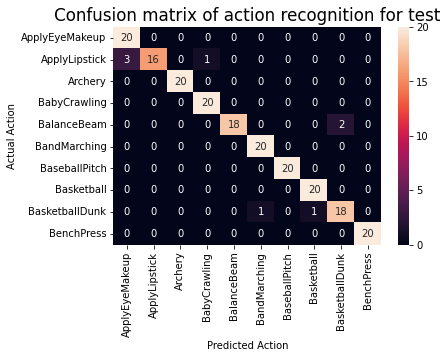

In [26]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')

## Next steps

Now that you have some familiarity with the MoViNet model and how to leverage various TensorFlow APIs (for example, for transfer learning), try using the code in this tutorial with your own dataset. The data does not have to be limited to video data. Volumetric data, such as MRI scans, can also be used with 3D CNNs. The NUSDAT and IMH datasets mentioned in [Brain MRI-based 3D Convolutional Neural Networks for Classification of Schizophrenia and Controls](https://arxiv.org/pdf/2003.08818.pdf) could be two such sources for MRI data.

In particular, using the `FrameGenerator` class used in this tutorial and the other video data and classification tutorials will help you load data into your models.

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)